In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os
import yaml

from utils import load_experiment_dir, get_min_loss

matplotlib.style.use('seaborn-notebook')
matplotlib.pyplot.rcParams['figure.figsize'] = (16, 10)
matplotlib.pyplot.rcParams['font.family'] = 'sans-serif'

%matplotlib inline

In [8]:
experiment_dir = "../exps/task2/track1/default"


def read_dev_loss_from_files(subdir):
    dev_acc_path = os.path.join(subdir.path, "dev.word_accuracy")
    if os.path.exists(dev_acc_path):
        with open(dev_acc_path) as f:
            return [float(f.read())]
    elif os.path.exists(os.path.join(subdir.path, "dev.word_accuracy.epoch_0000")):
        dev_acc = []
        for fn in os.listdir(subdir.path):
            if not fn.startswith('dev.word_accuracy') or 'epoch' not in fn:
                continue
            epoch = int(fn.split('_')[-1])
            with open(os.path.join(subdir.path, fn)) as f:
                acc = float(f.read())
                if len(dev_acc) <= epoch:
                    dev_acc.extend([0] * (epoch - len(dev_acc) + 1))
                dev_acc[epoch] = acc
        return dev_acc
    else:
        print("Dev accuracy file does not exist in dir: {}".format(subdir.path))
        
def load_task2_experiment_dir(basedir):
    experiments = []
    for subdir in os.scandir(basedir):
        exp_d = {}
        with open(os.path.join(subdir.path, "config.yaml")) as f:
            exp_d.update(yaml.load(f))
        res_fn = os.path.join(subdir.path, "result.yaml")
        if os.path.exists(res_fn):
            with open(os.path.join(subdir.path, "result.yaml")) as f:
                exp_d.update(yaml.load(f))
        else:
            continue
        exp_d['dev_acc'] = read_dev_loss_from_files(subdir)
        experiments.append(exp_d)
    experiments = pd.DataFrame(experiments)
    experiments['language'] = experiments.dev_file.apply(lambda s: s.split('/')[-1].split('-')[0])
    experiments = experiments.apply(get_min_loss, axis=1)
    experiments = experiments[experiments['dev_acc'].notnull()]
    experiments = experiments[experiments['dev_loss'].notnull()]
    experiments['train_size'] = experiments['train_file'].apply(lambda fn: fn.split('-')[-1])
    return experiments

experiments = load_task2_experiment_dir(experiment_dir)
experiments.shape

Dev accuracy file does not exist in dir: ../exps/task2/track1/default/0130


(147, 54)

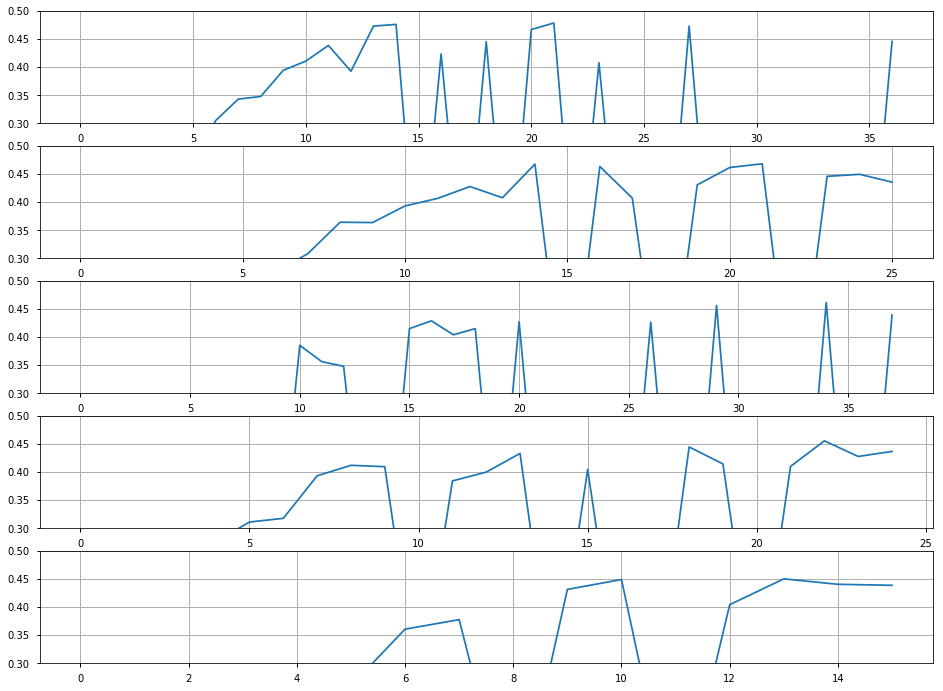

In [35]:
fr_medium = experiments[experiments.dev_acc.apply(len) > 1].copy()
fr_medium['dev_acc_max'] = fr_medium['dev_acc'].apply(max)
fig, ax = plt.subplots(5, 1, figsize=(16, 12))
for i, idx in enumerate(fr_medium.dev_acc_max.nlargest(5).index):
    ax[i].plot(fr_medium.loc[idx].dev_acc)
    ax[i].set_ylim((0.3, 0.5))
    ax[i].grid(True)

In [47]:
fr_medium.loc[fr_medium.dev_acc_max.nlargest(5).index].running_time / 3600

136    1.907866
138    2.805670
126    2.278629
132    1.661605
145    1.101882
Name: running_time, dtype: float64

In [50]:
fr_medium.columns

Index(['batch_size', 'cell_type', 'char_embedding_size', 'commit_hash',
       'context_hidden_size', 'context_num_layers', 'dataset_class',
       'decoder_hidden_size', 'decoder_num_layers', 'defaults', 'dev_acc',
       'dev_file', 'dev_loss', 'dropout', 'early_stopping_ratio',
       'early_stopping_strategy', 'early_stopping_window', 'epochs',
       'experiment_dir', 'generate_empty_subdir', 'include_same_forms_ratio',
       'lemma_hidden_size', 'lemma_num_layers', 'min_epochs', 'model', 'node',
       'numpy_random_seed', 'optimizer', 'optimizer_kwargs', 'overwrite_model',
       'running_time', 'save_attention_weights', 'save_min_epoch',
       'share_embedding', 'share_vocab', 'spaces', 'start_time',
       'tag_embedding_size', 'tag_hidden_size', 'tag_num_layers',
       'torch_random_seed', 'toy_eval', 'train_file', 'train_loss', 'use_eos',
       'use_step', 'vocab_path_src', 'vocab_path_tgt', 'word_hidden_size',
       'word_num_layers', 'language', 'min_dev_loss', 'min_t

In [83]:
params = ['batch_size', 'char_embedding_size', 'context_hidden_size', 'context_num_layers', 'dataset_class',
       'decoder_hidden_size', 'decoder_num_layers', 
       'dropout', 
       'early_stopping_strategy', 'early_stopping_window', 'epochs',
       'lemma_hidden_size', 'lemma_num_layers', 'min_epochs', 'model', 
       'optimizer', 
       'share_embedding', 'share_vocab', 
       'tag_embedding_size', 'tag_hidden_size', 'tag_num_layers',
       'word_hidden_size',
       'word_num_layers', ]


best = fr_medium.loc[fr_medium.dev_acc_max.idxmax()].loc[params]
    
#yaml.dump(best.to_dict())
dict(best.to_frame().T.iloc[0])

{'batch_size': 32,
 'char_embedding_size': 30,
 'context_hidden_size': 256,
 'context_num_layers': 1,
 'dataset_class': 'SIGMORPOHTask2Track1Dataset',
 'decoder_hidden_size': 64,
 'decoder_num_layers': 1,
 'dropout': 0.2,
 'early_stopping_strategy': 'dev_loss_increase',
 'early_stopping_window': 10.0,
 'epochs': 200,
 'lemma_hidden_size': 256,
 'lemma_num_layers': 1,
 'min_epochs': 0.0,
 'model': 'ContextInflectionSeq2seq',
 'optimizer': 'Adam',
 'share_embedding': False,
 'share_vocab': False,
 'tag_embedding_size': 30,
 'tag_hidden_size': 128,
 'tag_num_layers': 2,
 'word_hidden_size': 64,
 'word_num_layers': 2}

In [46]:
experiments.groupby('train_size').running_time.describe()

,count,mean,std,min,25%,50%,75%,max
train_size,,,,,,,,
high,38.0,9656.159817,4930.499519,3005.681581,6406.571121,7961.682559,11962.748384,25449.532785
low,38.0,910.367687,767.371095,88.384087,372.567840,628.289579,1123.515816,2927.419094
medium,71.0,3959.618859,3856.421752,277.994170,1275.533826,3220.518675,5779.766970,24662.202256


In [4]:
experiments['early_stopping_strategy'] = experiments['early_stopping_strategy'].fillna('ratio')
experiments.groupby(['language', 'train_size']).size()

language  train_size
de        high          5
          low           6
          medium        6
en        high          6
          low           6
          medium        6
es        high          6
          low           6
          medium        6
fi        high          5
          low           5
          medium        5
fr        high          6
          low           5
          medium        9
ru        high          5
          low           5
          medium        5
sv        high          5
          low           5
          medium        5
dtype: int64

In [26]:
experiments.groupby(['language', 'early_stopping_strategy']).dev_acc.agg(['max', 'mean'])

max      mean
language early_stopping_strategy                    
de       dev_loss_increase        0.696697  0.512513
         ratio                    0.735736  0.415273
en       dev_loss_increase        0.714114  0.607592
         ratio                    0.732558  0.545442
es       dev_loss_increase        0.527104  0.358308
         ratio                    0.551344  0.323814
fi       ratio                    0.437533  0.210314
fr       ratio                    0.671299  0.381647
ru       ratio                    0.692633  0.359808
sv       ratio                    0.691638  0.375610

In [5]:
fr = load_task2_experiment_dir("../../deep-morphology/exps/sigmorphon/task2_track1/")

Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0136
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0024
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0026
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0027
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0028
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0029
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0030
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0033
Dev accuracy file does not exist in dir: ../../deep-morphology/exps/sigmorphon/task2_track1/0077


FileNotFoundError: [Errno 2] No such file or directory: '../../deep-morphology/exps/sigmorphon/task2_track1/0006/config.yaml'